In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
df1 = pd.read_csv(r'/content/GOOG.csv')
df2 = pd.read_csv(r'/content/AMZN.csv')
df3= pd.read_csv(r'/content/^NSEI.csv')
df1['company']='GOOG'
df2['company']='AMZN'
df3['company']='NSEI'

In [ ]:
df=pd.concat([df1,df2,df3])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company
0,2010-05-31,246.630569,253.674164,246.426331,248.428833,248.428833,15198755,GOOG
1,2010-06-07,248.598190,249.519745,235.118713,243.337906,243.337906,26913301,GOOG
2,2010-06-14,246.316742,251.990479,240.189713,249.081375,249.081375,26979750,GOOG
3,2010-06-21,249.016632,249.549622,234.401413,235.457443,235.457443,22827443,GOOG
4,2010-06-28,235.412613,237.883362,216.005356,217.459900,217.459900,28741728,GOOG


In [ ]:
df.shape

(1727, 8)

In [ ]:
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [ ]:


train = df[df['Date']<'2019-01-01']
test = df[df['Date']>='2019-01-01']

LSTM MODEL

In [ ]:
def modelLSTM(x_train ,y_train,x_test,mms):
  model = Sequential()
  model.add(LSTM(units = 13, input_shape = (x_train.shape[1],1),return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=13))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  model.compile(optimizer = 'adam' , loss = 'mean_squared_error')
  train = model.fit(x_train, y_train, epochs = 30, batch_size = 10, validation_split=0.20,verbose=0)
  y_predict=model.predict(x_test)
  y_predict=mms.inverse_transform(y_predict)
  return y_predict

0.9656799614985744


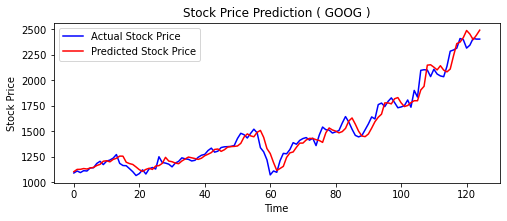

0.9630931341093508


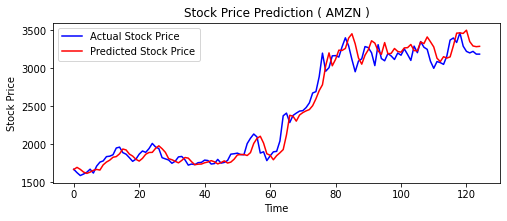

0.9240878518374225


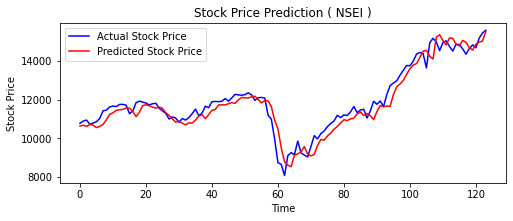

In [ ]:
for j,company in enumerate(train['company'].unique()):
  x_train=[]
  y_train=[]
  t=train[train['company']==company]
  mms = MinMaxScaler()
  train_set = t[['Adj Close']]
  train_set_scaled = mms.fit_transform(train_set)
  N = len(train_set_scaled)
  batch=2
  for i in range ( batch , N):
    x_train.append(train_set_scaled[i-batch:i,0])
    y_train.append(train_set_scaled[i,0])

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
  test_set = test[test['company']==company]
  test_set=test_set[['Adj Close']]
  mms2 = MinMaxScaler()
  test_scaled = mms2.fit_transform(test_set)
  y_test=test_set[batch:]
  y_test=y_test.reset_index()
  x_test =[]
  M = len(test_set)
  for i in range (2,M):
    x_test.append(test_scaled[i-2:i,0])
  x_test=np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
  y_predict= modelLSTM(x_train,y_train,x_test,mms2)
  y_true = np.array(y_test)
  y_true = y_true[:,1]
  y_predict
  print(r2_score(y_true, y_predict[:,0]))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,j+1)
  plt.plot(y_test['Adj Close'], color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction ( '+company+' )')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

LAST VALUE MODEL

0.9952580458644944


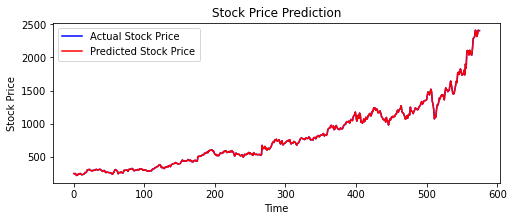

0.9967836158405946


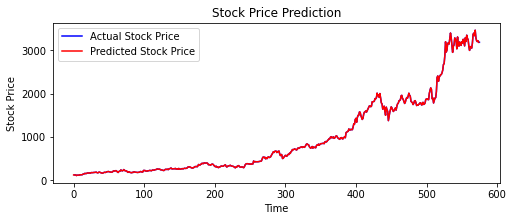

0.9938198364802129


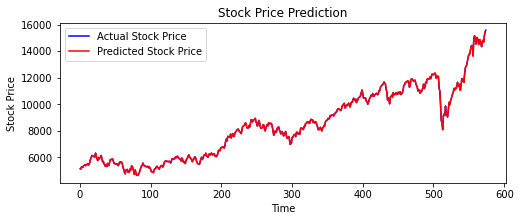

In [ ]:
for i,company in enumerate(df['company'].unique()):
  y_predict=df[df['company']==company]['Adj Close'][:-1]
  y_true =df[df['company']==company]['Adj Close'][1:]
  print(r2_score(y_true, y_predict))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,i+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

MOVING AVERAGE 

1727
0.9942579301398874


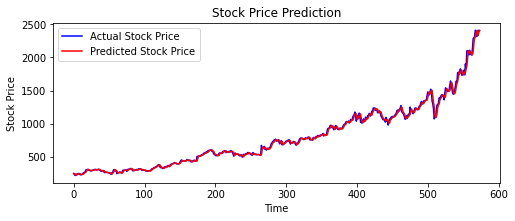

1727
0.9960254415118988


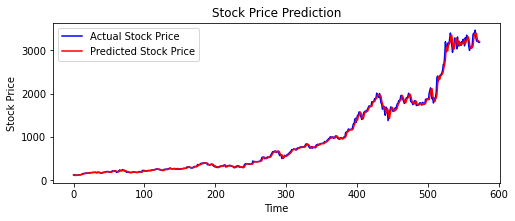

1727
0.9919996855418526


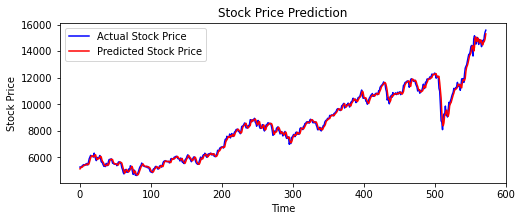

In [ ]:
for i,company in enumerate(df['company'].unique()):
  N=2
  print(len(df))
  y_predict=[]
  y_true=[]
  for j in range(N,len(df[df['company']==company])):
    y_predict.append(sum(df[df['company']==company]['Adj Close'][j-N:j])/2)
    y_true.append(df[df['company']==company]['Adj Close'][j])
  print(r2_score(y_true, y_predict))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,i+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

LINEAR REGRESSION

0.9741307144657972


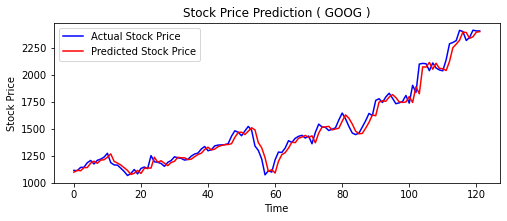

0.9776340041158584


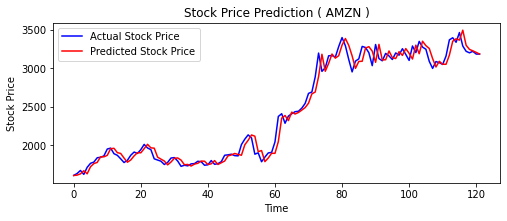

0.9576930561154323


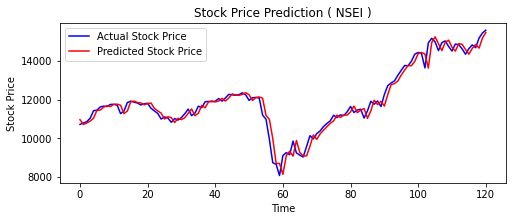

In [ ]:
from sklearn.linear_model import LinearRegression
for j,company in enumerate(train['company'].unique()):
  x_train=[]
  y_train=[]
  train_set=train[train['company']==company]['Adj Close']
  N = len(train_set)
  batch = 5
  for i in range( batch , N):
    x_train.append(train_set[i-batch:i])
    y_train.append(train_set[i])
  reg = LinearRegression().fit(x_train,y_train)
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  reg = LinearRegression().fit(x_train, y_train)
  #print(x_train.shape)
  #print(y_train.shape)
  test_set=test[test['company']==company]['Adj Close']
  y_test=test_set[batch:]
  y_test=y_test.reset_index()
  y_true=y_test['Adj Close']
  x_test =[]
  M = len(test_set)
  for i in range (batch,M):
    x_test.append(test_set[i-batch:i])
  x_test=np.array(x_test)
  y_predict = reg.predict(x_test)
  print(r2_score(y_true, y_predict))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,j+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction ( '+company+' )')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

XGBOOST 

[12:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9662246060057704


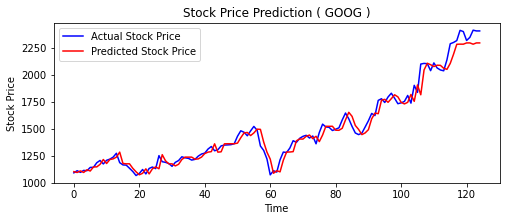

[12:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9685169303180098


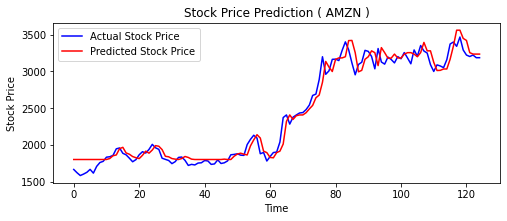

[12:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9363245919236355


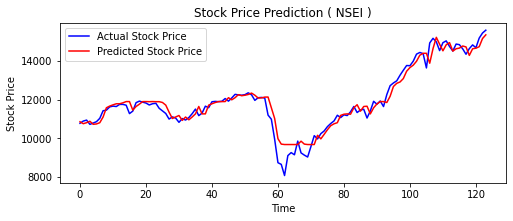

In [ ]:
from xgboost import XGBRegressor


for j,company in enumerate(train['company'].unique()):
  x_train=[]
  y_train=[]
  ss= StandardScaler()

  model = XGBRegressor(max_depth= 10,
                       n_estimators= 1000,seed=42,gamma= 0.01,
                       learning_rate= 0.01)
  train_set=train[train['company']==company]
  train_set=train_set[['Adj Close']]
  train_set_scaled = ss.fit_transform(train_set)
  N = len(train_set)
  batch = 2
  for i in range( batch , N):
    x_train.append(train_set_scaled[i-batch:i,0])
    y_train.append(train_set_scaled[i,0])
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  model.fit(x_train, y_train)
  test_set=test[test['company']==company]['Adj Close']
  y_test=test_set[batch:]
  test_set=test[test['company']==company]
  test_set=test_set[['Adj Close']]
  
  y_test=y_test.reset_index()
  y_true=y_test['Adj Close']
  x_test =[]
  M = len(test_set)
  ss2=StandardScaler()
  test_set_scaled=ss2.fit_transform(test_set)
  for i in range (batch,M):
    x_test.append(test_set_scaled[i-batch:i,0])
  x_test=np.array(x_test)
  y_predict = model.predict(x_test)
  #print(y_predict)
  y_predict=ss2.inverse_transform(y_predict)
  print(r2_score(y_predict,y_true))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,j+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction ( '+company+' )')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()